In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
from collections import Counter
from sklearn.impute import SimpleImputer
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, StandardScaler, power_transform
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve,auc, r2_score

Using TensorFlow backend.


In [2]:
pd.options.display.float_format = '{:,.2f}'.format
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('Train.csv')

In [4]:
df.head(2)

,Applicant_ID,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field47,form_field48,form_field49,form_field50,default_status
0,Apcnt_1000000,"3,436.00",0.29,1.66,0.00,0.00,0.00,"10,689,720.00","252,072.00","4,272,776.00","11,333,126.00","4,397,256.00","2,301,324.00","7,875,694.00",96375139,"112,181,765.00",1.00,1.00,1.00,3.00,3.00,134.66,nan,nan,134.66,"4,000.50","17,064.00","11,376.00",60.00,"17,064.00","5,962.00",nan,"1,052.00",8.00,2.00,nan,12.00,12.00,4.00,0.00,nan,nan,0.39,2.02,0.71,0.00,0.00,charge,nan,1.13,0.04,no
1,Apcnt_1000004,"3,456.00",0.67,0.23,0.00,0.00,0.00,"898,979.00","497,531.00","9,073,814.00","2,533,168.00","244,292.00","3,982,971.00","2,141,445.00",28141427,"45,169,902.00",1.00,1.00,1.00,2.00,2.00,109.23,"11,385.24","14,584.29",86.69,"4,161.00","13,413.00","8,942.00",304.00,"13,413.00","5,780.00",nan,"2,554.00",17.50,0.00,0.00,16.00,24.00,8.00,0.00,nan,nan,0.31,8.08,0.18,nan,0.00,charge,349.81,1.62,0.32,no


In [5]:
# PERCENTAGE OF MISSING VALUES
(df.isna().sum().sort_values(ascending = False)/len(df))*100

form_field40     78.09
form_field31     70.37
form_field41     68.27
form_field11     56.11
form_field45     55.92
form_field23     50.22
form_field30     45.55
form_field35     41.34
form_field15     40.13
form_field48     37.30
form_field22     36.43
form_field46     28.40
form_field21     28.31
form_field6      23.86
form_field8      23.86
form_field24     23.74
form_field16     23.28
form_field17     19.91
form_field50     19.74
form_field18     18.57
form_field12     17.67
form_field27     16.61
form_field9      14.30
form_field26     13.28
form_field13     10.52
form_field25      9.73
form_field32      9.73
form_field37      9.73
form_field44      9.61
form_field7       9.22
form_field39      7.52
form_field2       6.86
form_field1       4.52
form_field36      3.56
form_field42      2.36
form_field33      2.24
form_field43      1.01
form_field5       0.63
form_field49      0.63
form_field10      0.63
form_field3       0.63
form_field28      0.63
form_field38      0.63
form_field3

In [6]:
# CONVERTING NON NUMERIC FIELD TO NUMERIC FIELD.
df['form_field47'] = df['form_field47'].replace({'charge': 0, 'lending': 1})
df['default_status'] = df['default_status'].replace({'yes': 1, 'no': 0})
# THESE COLUMNS HAS 50% AND ABOVE MISSING VALUES THEREFORE WILL BE DROPPED
drop_col = ['form_field40', 'form_field31', 'form_field41', 'form_field11', 'form_field45']
df1 = df.drop(drop_col, axis = 1)

In [7]:
# FEATURE ENGINEERING: ADDED COLUMNS THAT HAVE HIGH POSITIVE COLORATION FROM .70
df1['form_field7_10'] = df1['form_field10'] - df1['form_field7']
# df1['form_field16_17_18'] = df1['form_field16'] + df1['form_field17'] + df1['form_field18']
df1['form_field19_20'] = df1['form_field19'] + df1['form_field20']
df1['form_field21_22_23'] = df1['form_field21'] + df1['form_field22'] + df1['form_field23']
df1['form_field25_26_27'] = df1['form_field25'] + df1['form_field26'] + df1['form_field27']
df1['form_field32_37'] = df1['form_field32'] * df1['form_field37']

In [8]:
col_drop = ['Applicant_ID','form_field4', 'form_field5','form_field7','form_field9','form_field10', 'form_field16',
            'form_field17', 'form_field18', 'form_field19', 'form_field20', 'form_field21', 'form_field22', 
            'form_field23', 'form_field25', 'form_field26', 'form_field27','form_field32', 'form_field34', 
            'form_field35', 'form_field37', 'form_field39', 'form_field46']

# DROPPING THE COLUMNS WITH ZERO(0) AT 75 QUARTILE AND COLUMNS USE FOR FEATURE ENGINEERING\
df2 = df1.drop(col_drop, axis = 1)
# df2 = df1.copy()

In [9]:
5,19,20,46,39

(5, 19, 20, 46, 39)

In [10]:
# REARRANGING THE COLUMNS 
# col_order = ['form_field1', 'form_field2', 'form_field3',
#        'form_field4', 'form_field5', 'form_field6', 'form_field7',
#        'form_field8', 'form_field9', 'form_field10', 'form_field12',
#        'form_field13', 'form_field14', 'form_field15', 'form_field16',
#        'form_field17', 'form_field18', 'form_field19', 'form_field20',
#        'form_field21', 'form_field22', 'form_field23', 'form_field24',
#        'form_field25', 'form_field26', 'form_field27', 'form_field28',
#        'form_field29', 'form_field30', 'form_field32', 'form_field33',
#        'form_field34', 'form_field35', 'form_field36', 'form_field37',
#        'form_field38', 'form_field39', 'form_field42', 'form_field43',
#        'form_field44', 'form_field46', 'form_field47', 'form_field48',
#        'form_field49', 'form_field50', 'form_field7_10',
#        'form_field19_20', 'form_field21_22_23', 'form_field25_26_27',
#        'form_field32_37', 'default_status']
col_order = ['form_field1', 'form_field2', 'form_field3','form_field6', 'form_field8', 
             'form_field12', 'form_field13', 'form_field14', 'form_field15', 'form_field24',
             'form_field28', 'form_field29', 'form_field30', 'form_field33', 'form_field36', 'form_field38', 
             'form_field42', 'form_field43', 'form_field44', 'form_field47', 'form_field48', 'form_field49',
             'form_field50', 'form_field7_10', 'form_field19_20', 'form_field21_22_23', 
             'form_field25_26_27', 'form_field32_37', 'default_status']
df3 = df2[col_order]

In [11]:
df3.head(2)

,form_field1,form_field2,form_field3,form_field6,form_field8,form_field12,form_field13,form_field14,form_field15,form_field24,form_field28,form_field29,form_field30,form_field33,form_field36,form_field38,form_field42,form_field43,form_field44,form_field47,form_field48,form_field49,form_field50,form_field7_10,form_field19_20,form_field21_22_23,form_field25_26_27,form_field32_37,default_status
0,"3,436.00",0.29,1.66,0.00,"252,072.00","2,301,324.00","7,875,694.00",96375139,"112,181,765.00",134.66,60.00,"17,064.00","5,962.00",8.00,12.00,4.00,0.39,2.02,0.71,0,nan,1.13,0.04,"643,406.00",6.00,nan,"32,440.50","12,624.00",0
1,"3,456.00",0.67,0.23,0.00,"497,531.00","3,982,971.00","2,141,445.00",28141427,"45,169,902.00",86.69,304.00,"13,413.00","5,780.00",17.50,16.00,8.00,0.31,8.08,0.18,0,349.81,1.62,0.32,"1,634,189.00",4.00,"26,078.76","26,516.00","61,296.00",0


In [12]:
# TO REMOVE OUTLIERS
def removeoutliers(df_, columns=None, factor=1.5, method='IQR', treatment='cap'):
    """
    Removes the rows from self.df whose value does not lies in the specified standard deviation
    :param columns:
    :param in_stddev:
    :return:
    """
    df = df_.copy()
    for column in columns:
        if method == 'STD':
            permissable_std = factor * df[column].std()
            col_mean = df[column].mean()
            floor, ceil = col_mean - permissable_std, col_mean + permissable_std
            
        elif method == 'IQR':
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            floor, ceil = Q1 - factor * IQR, Q3 + factor * IQR
        
        if treatment == 'remove':
            df1 = df[(df[column] >= floor) & (df[column] <= ceil)]
        elif treatment == 'cap':
            df[column] = df[column].clip(floor, ceil)
            df1 = df.copy()
    return df1

In [13]:
# # HANDLING OUTLIERS
col1 = df3.columns[:-1]
df4 = removeoutliers(df_ = df3, columns = col1)
# df4 = df3.copy()

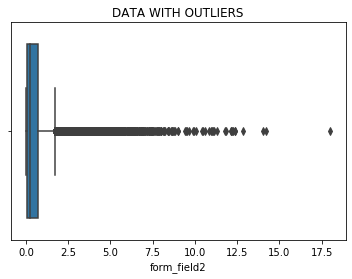

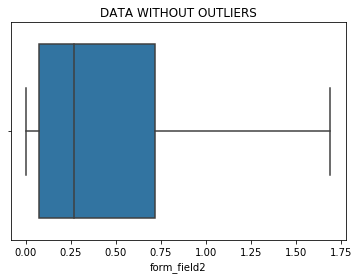

In [14]:
# DETECTING OUTLIERS
sns.boxplot(x=df3['form_field2'])
plt.title('DATA WITH OUTLIERS')
plt.show()
sns.boxplot(x=df4['form_field2'])
plt.title('DATA WITHOUT OUTLIERS')
plt.show()

In [15]:
# COLUMNS TO DROP BECAUSE THEIR 75 QUARTILE IS ZERO
col_drop = ['form_field4', 'form_field5', 'form_field16', 'form_field17', 'form_field18', 'form_field34',
           'form_field35', 'form_field39', 'form_field45', 'form_field46']

In [16]:
# COLUMNS TO DROP BECAUSE THEY ARE USED FOR FEATURE ENGINEERING
col_drop = [['form_field10', 'form_field7'], ['form_field32', 'form_field9'],
           ['form_field16', 'form_field17', 'form_field18'], ['form_field19', 'form_field20'], ['form_field21',
           'form_field22', 'form_field23'],['form_field25', 'form_field26', 'form_field27'] ,
           ['form_field32', 'form_field37'], ['form_field46', 'form_field4']]

In [17]:
df4.describe()

,form_field1,form_field2,form_field3,form_field6,form_field8,form_field12,form_field13,form_field14,form_field15,form_field24,form_field28,form_field29,form_field30,form_field33,form_field36,form_field38,form_field42,form_field43,form_field44,form_field47,form_field48,form_field49,form_field50,form_field7_10,form_field19_20,form_field21_22_23,form_field25_26_27,form_field32_37,default_status
count,"53,471.00","52,156.00","55,645.00","42,640.00","42,640.00","46,105.00","50,111.00","56,000.00","33,525.00","42,703.00","55,645.00","55,645.00","30,491.00","54,744.00","54,005.00","55,645.00","54,677.00","55,432.00","50,617.00","56,000.00","35,111.00","55,645.00","44,944.00","50,837.00","55,645.00","25,508.00","46,701.00","50,550.00","56,000.00"
mean,"3,491.80",0.47,0.75,"350,121.67","2,350,373.92","2,238,535.15","3,722,391.92","34,730,615.37","105,199,206.56",72.47,"17,274.32","16,361.79","5,212.21",13.52,12.15,8.21,0.36,6.48,0.56,0.35,814.63,0.79,0.34,"4,413,623.90",1.43,"13,850.73","18,766.72","10,659.12",0.24
std,188.46,0.51,1.12,"458,065.76","2,870,843.18","2,527,368.48","4,587,228.99","24,343,026.35","73,972,070.57",65.44,"26,930.74","9,191.71","3,120.25",13.94,8.16,6.45,0.40,5.82,0.20,0.48,"1,002.77",1.08,0.38,"6,232,860.04",1.88,"10,591.91","14,313.38","14,019.25",0.43
min,"2,990.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,"539,543.00",0.00,0.00,0.00,0.00,0.17,2.00,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.00,"-10,557,849.00",0.00,0.26,0.00,0.00,0.00
25%,"3,358.00",0.07,0.00,"14,004.00","192,944.00","275,801.00","192,166.00","16,576,457.00","50,076,359.00",14.87,60.00,"9,765.00","2,312.00",2.33,6.00,4.00,0.00,2.02,0.41,0.00,77.10,0.00,0.05,"53,682.00",0.00,"4,037.97","7,273.50",184.00,0.00
50%,"3,484.00",0.27,0.06,"115,533.00","963,942.00","1,163,110.00","1,605,792.00","28,141,427.00","84,424,281.00",60.66,486.00,"15,057.00","5,658.00",7.83,10.00,6.00,0.22,5.05,0.59,0.00,318.12,0.00,0.17,"1,477,422.00",0.00,"12,788.61","15,947.00","3,384.00",0.00
75%,"3,620.00",0.72,1.28,"525,928.00","3,751,516.00","3,360,182.00","5,593,625.50","48,187,375.00","142,873,476.00",114.71,"60,772.00","21,810.00","7,726.00",21.17,16.00,12.00,0.63,10.10,0.75,1.00,"1,153.02",1.18,0.50,"7,128,036.00",2.00,"22,713.47","26,645.00","16,492.00",0.00
max,"3,900.00",1.69,3.20,"1,293,814.00","9,089,374.00","7,986,753.50","13,695,814.75","95,603,752.00","282,069,151.50",264.48,"60,772.00","39,877.50","15,847.00",49.42,31.00,24.00,1.57,22.22,0.80,1.00,"2,766.90",2.95,1.18,"17,739,567.00",5.00,"50,726.73","55,702.25","40,954.00",1.00


In [18]:
# MISSING DATA
df4['form_field32_37'] = df4['form_field32_37'].fillna(-999)
df4['form_field25_26_27'] = df4['form_field25_26_27'].fillna(-999)
df4['form_field19_20'] = df4['form_field19_20'].fillna(-999)
df4['form_field50'] = df4['form_field50'].fillna(-999)
df4['form_field49'] = df4['form_field49'].fillna(-999)
# df4['form_field48'] = df4['form_field48'].fillna(-999)
df4['form_field47'] = df4['form_field47'].fillna(-999)
df4['form_field43'] = df4['form_field43'].fillna(-999)
df4['form_field42'] = df4['form_field42'].fillna(-999)
# df4['form_field38'] = df4['form_field38'].fillna(-999)
df4['form_field30'] = df4['form_field30'].fillna(-999)
df4['form_field29'] = df4['form_field29'].fillna(-999)
df4['form_field28'] = df4['form_field28'].fillna(-999)
df4['form_field24'] = df4['form_field24'].fillna(-999)
# df4['form_field14'] = df4['form_field14'].fillna(-999)
df4['form_field13'] = df4['form_field13'].fillna(-999)
df4['form_field12'] = df4['form_field12'].fillna(-999)
# df4['form_field9'] = df4['form_field9'].fillna(-999)
df4['form_field8'] = df4['form_field8'].fillna(0)
df4['form_field6'] = df4['form_field6'].fillna(0)
df4['form_field3'] = df4['form_field3'].fillna(-999)
df4['form_field2'] = df4['form_field2'].fillna(-999)
# df4['form_field1'] = df4['form_field1'].fillna(df4['form_field1'].min())
# FILLING MISSING DATA
simple_imputter = SimpleImputer(missing_values = np.nan, strategy = 'mean')
df5 = simple_imputter.fit_transform(df4)
# CONVERTING FROM NDARRAY TO PANDAS DATAFRAME
df6 = pd.DataFrame(columns = df4.columns, index = range(len(df4)), data = df5[:])
pre_y = df6[['default_status']].astype(int)
pre_x = df6.drop(['default_status'], axis =1)

In [19]:
# # FEATURE ENGINEERING


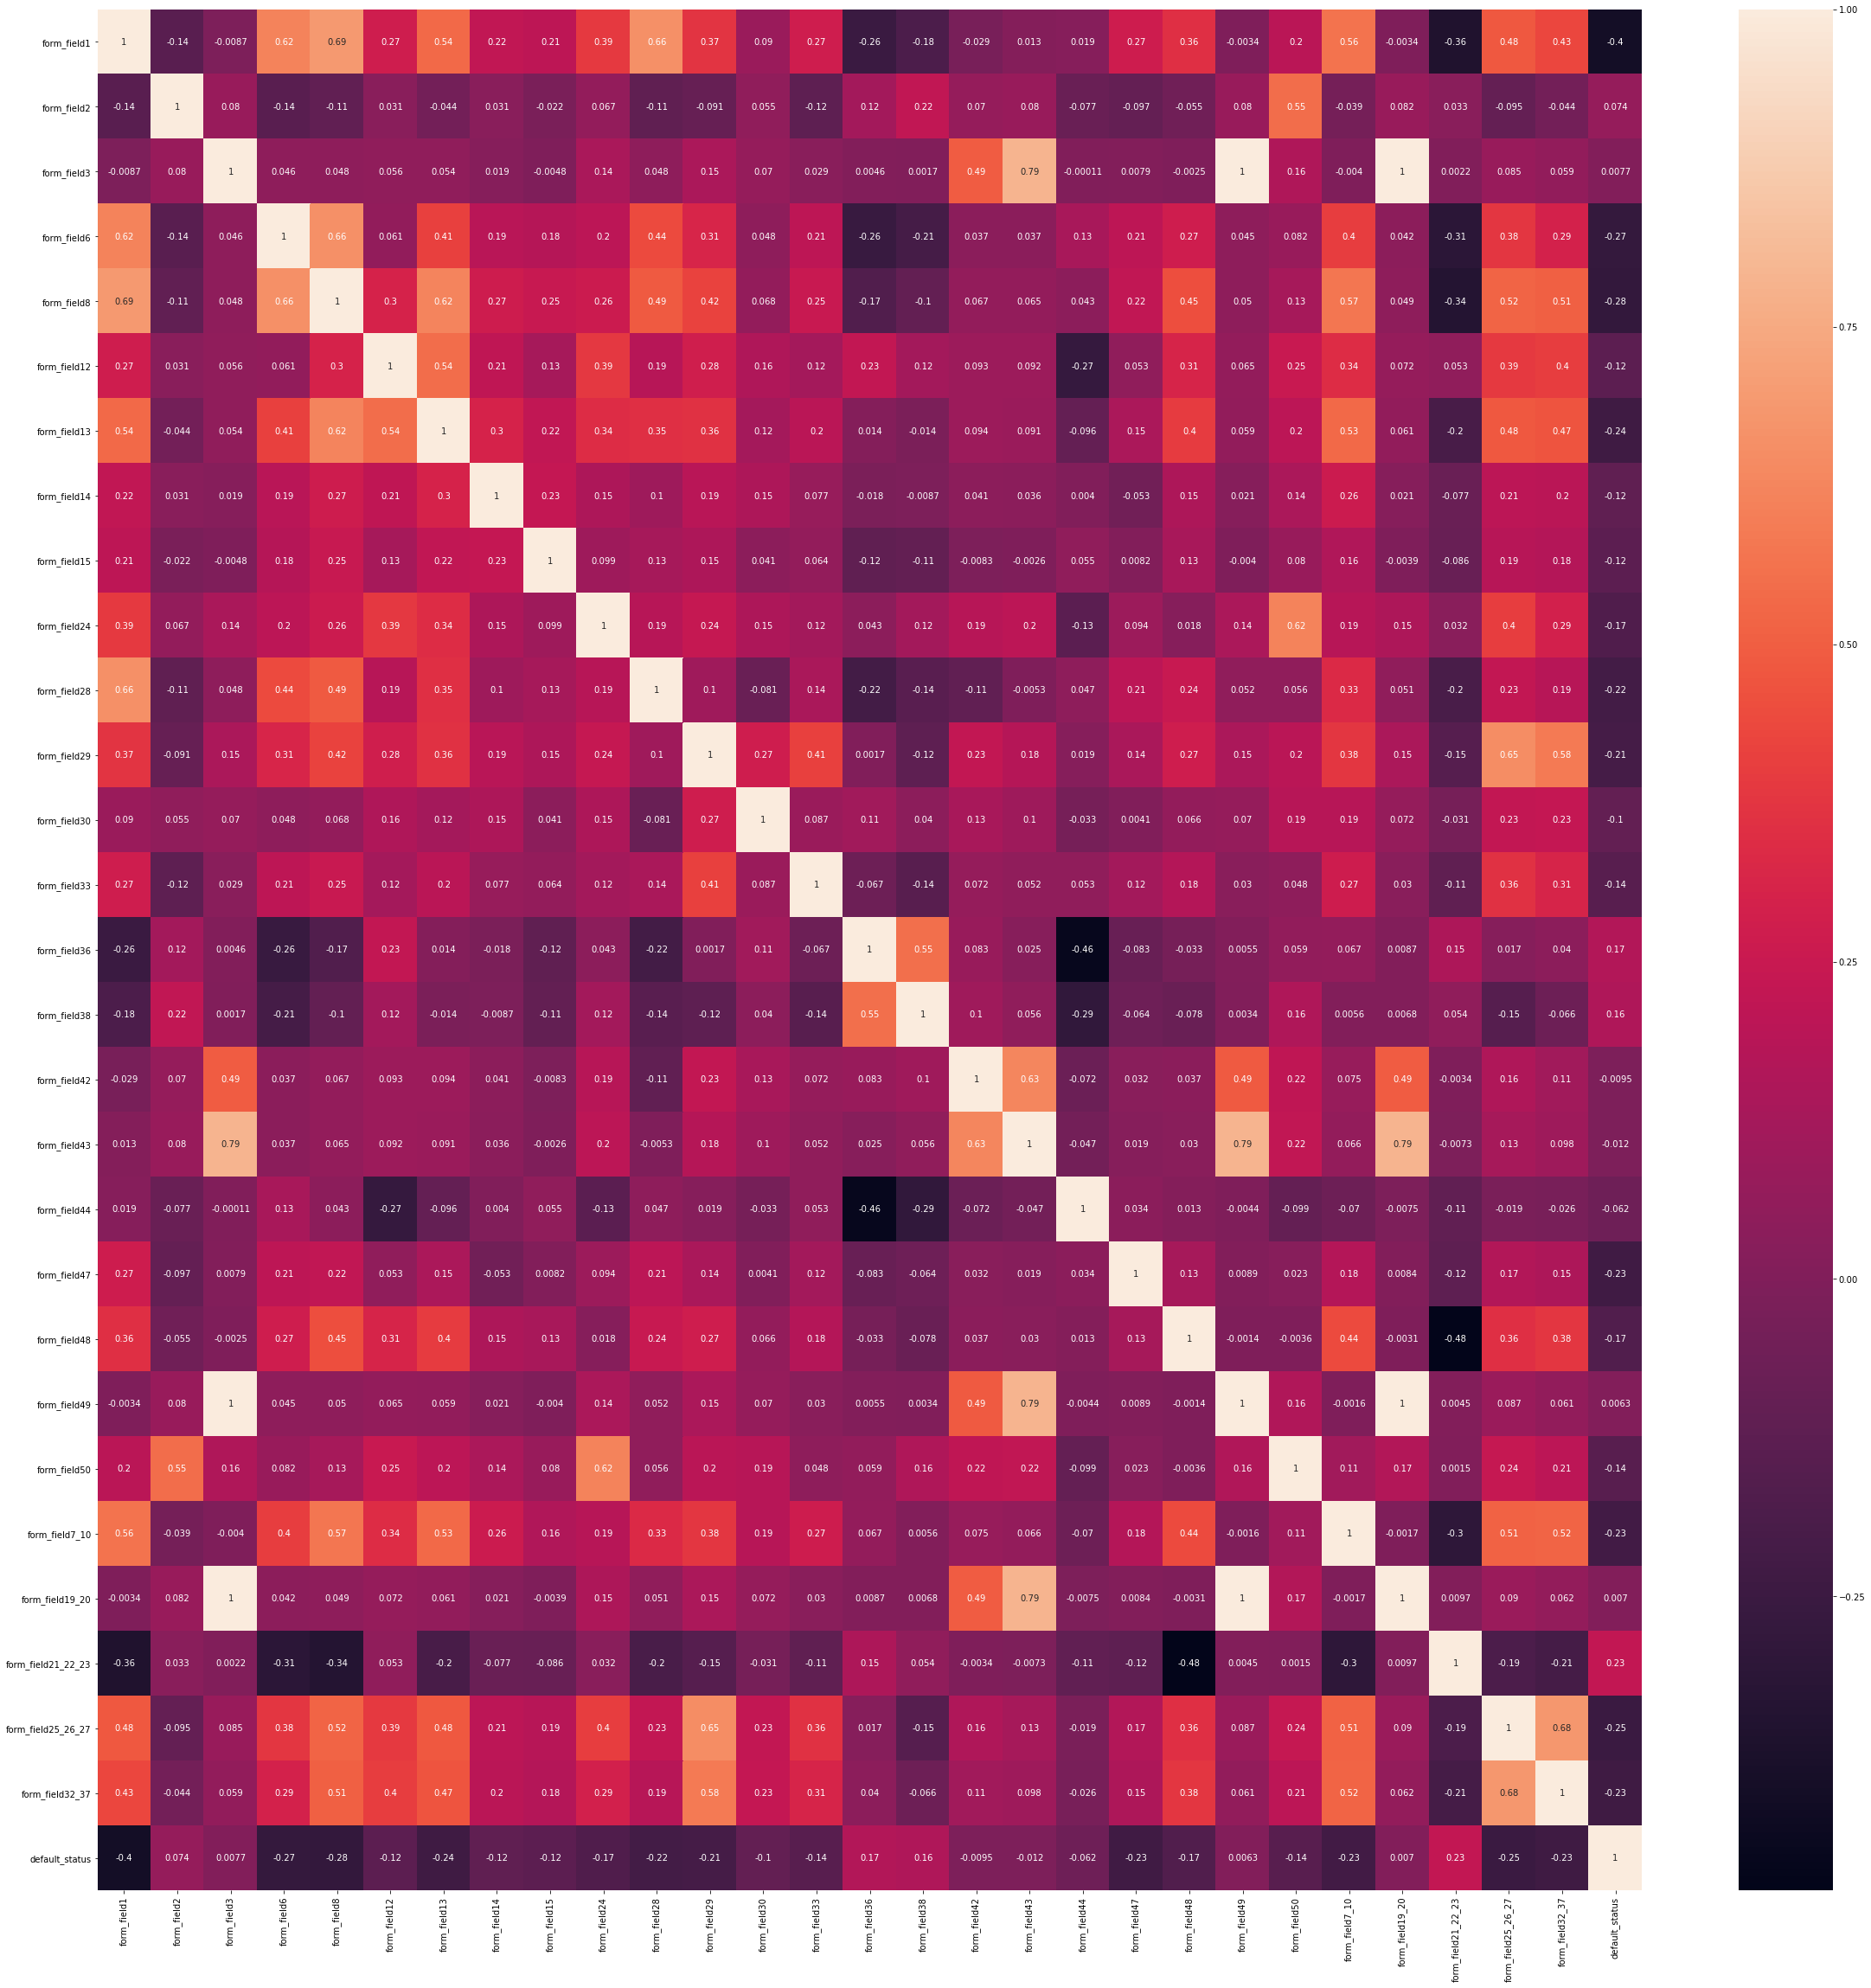

In [20]:
plt.figure(figsize=(40,40))
sns.heatmap(df6.corr(),xticklabels=df6.columns, yticklabels=df6.columns, annot=True)

In [21]:
# BALANCING AND SCALING THE DATASET
# smote = SMOTE(sampling_strategy = 'not minority')
# X1, y = smote.fit_sample(pre_x, pre_y)
# sc = StandardScaler()
# X = sc.fit_transform(X1)

smote = SMOTE(sampling_strategy = 'not minority')
X1, y = smote.fit_sample(pre_x, pre_y)
X = power_transform(X1,  method='yeo-johnson')

In [22]:
# splitting the dataset
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.1, random_state = 42)

In [23]:
# TRAIN DATA USING RANDOM FOREST
# n_estimators=1000, max_depth=100, min_samples_leaf=10, min_samples_split=100,n_jobs=10 
rf = RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=100, min_samples_split=10, 
                            min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', 
                            max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                            bootstrap=True, oob_score=False, n_jobs= 10, random_state=None, verbose=0, 
                            warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
model = rf.fit(X_train, y_train.values.ravel())

In [24]:
y_pred = model.predict_proba(X_test)[:,1]
r2_score(y_test,y_pred)

0.2655116437864391

In [25]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
metrics.auc(fpr, tpr)

0.829361697478257

In [26]:
# 0.2664920991037695
# 0.8299849971045845

In [27]:
# SAVING THE MODEL FINAL HACKATHON RF5 HAS THE BEST SCORE
import pickle
from sklearn.externals import joblib
filename = 'Final Hackathon RF6.pkl'
joblib.dump(model, filename)

c:\users\uuruakpa\appdata\local\programs\python\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['Final Hackathon RF6.pkl']

In [28]:

def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

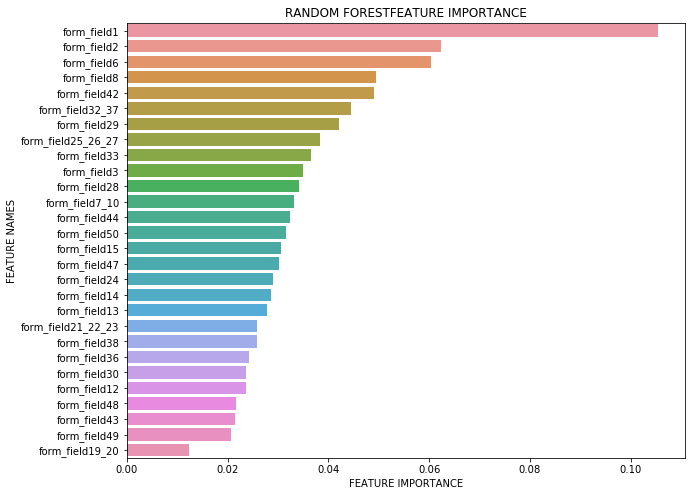

In [29]:
plot_feature_importance(model.feature_importances_, pre_x.columns,'RANDOM FOREST') 